<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/ml/keras/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST を使用した画像分類のデモ

## データの読み込み



バージョンとデバイス確認

In [1]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU(s): {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.14.0
GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


再現性のために乱数のシードを固定

In [2]:
tf.keras.utils.set_random_seed(42)

データの用意

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
# 規格化
x_train, x_test = x_train / 255.0, x_test / 255.0

print(f"train dataset shape={x_train.shape}")

train dataset shape=(60000, 28, 28)


## NN (平坦化 & 全結合層)で解く

3層の全結合層モデルを定義。
```
Dense(x) = activation(dot(x, kernel) + bias)
sigmoid(x) = 1 / (1 + exp(-x))
```
である。Dense には activation まで含まれる。
詳細は[ここ](https://keras.io/api/layers/)。

In [4]:
simple_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  # 出力の形状と活性化層を定義
  tf.keras.layers.Dense(50, activation='sigmoid'),
  tf.keras.layers.Dense(100, activation='sigmoid'),
  # 最終層は出力層が確率の公理を満たすように
  # sigmoid ではなく Softmax で活性化
  tf.keras.layers.Dense(10),
  tf.keras.layers.Softmax()
])
# サマリ出力
simple_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 50)                39250     
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
 softmax (Softmax)           (None, 10)                0         
                                                                 
Total params: 45360 (177.19 KB)
Trainable params: 45360 (177.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


各画像は 28x28。データ数は60000。

test data set shape=(10000, 28, 28)


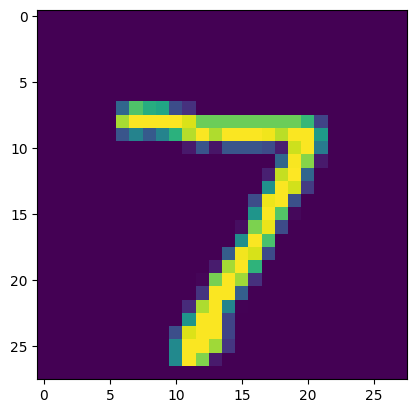

In [5]:
import matplotlib.pyplot as plt

print(f"test data set shape={x_test.shape}")
plt.imshow(x_test[0, ...])

試しに1サンプルで推論してみる。
未学習なので不正解になる。

入力はバッチになっている必要がある。この場合はデータ数1のバッチとして渡している。

In [6]:
import numpy as np

single_batch = x_test[:1]
print(f"size of single_batch = {single_batch.shape}\n")

predictions = simple_model(single_batch).numpy()
print(f"probs for single_batch=\n{predictions[0]}\n")
print(f"estimation for single_batch={np.argmax(predictions[0])}")

size of single_batch = (1, 28, 28)

probs for single_batch=
[0.11055059 0.20118855 0.07267059 0.04651801 0.1436727  0.10791311
 0.07552891 0.08780097 0.11729486 0.03686176]

estimation for single_batch=1


交差エントロピーによる損失計算

In [7]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
print(f"spase categorical cross entropy = {loss_fn(y_train[:1], predictions).numpy():.4f}")

spase categorical cross entropy = 2.2264


学習方法(最適化手法・損失関数・メトリック)を指定

In [8]:
simple_model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

学習を実施

In [9]:
simple_model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 12s 5ms/step - loss: 0.5386 - accuracy: 0.8620
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2051 - accuracy: 0.9395
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1517 - accuracy: 0.9554
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1214 - accuracy: 0.9639
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1007 - accuracy: 0.9704


評価。全結合層だけでも正答率 96.5%。

In [10]:
simple_model.evaluate(x_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.1145 - accuracy: 0.9646 - 730ms/epoch - 2ms/step


[0.11446036398410797, 0.9646000266075134]

再度推論を実施。正答する。

In [11]:
predictions = simple_model(single_batch).numpy()
print(f"probs for single_batch={predictions[0]}\n")
print(f"estimation for single_batch={np.argmax(predictions[0])}")

probs for single_batch=[5.8883683e-07 1.6797845e-05 1.4496848e-03 5.6367187e-04 3.5158365e-07
 9.1590491e-06 2.8727579e-10 9.9785346e-01 3.0062984e-06 1.0325099e-04]

estimation for single_batch=7


不正解の例を見てみる

prediction = 6
answer = 5


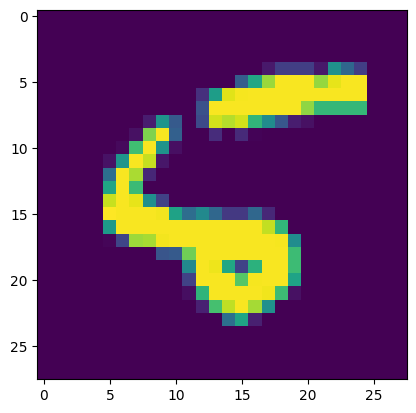

In [12]:
probs = simple_model(x_test).numpy()
preds = np.argmax(probs, axis=1)
false_mask = preds != y_test

false_images = x_test[false_mask]

print(f"prediction = {preds[false_mask][0]}")
print(f"answer = {y_test[false_mask][0]}")
plt.imshow(false_images[0])

## CNN で解く

Conv2D と MaxPool2D を利用して特徴量学習。Dense で分類を実施。

In [13]:
cnn_model = tf.keras.models.Sequential([
  # filters = 学習するフィルタの数・出力チャンネル数
  # valid = padding なし
  tf.keras.layers.Conv2D(filters=30, kernel_size=(5, 5),
                         padding="valid", strides=1, activation="relu",
                         input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPool2D((2, 2)),
  tf.keras.layers.Flatten(input_shape=(12, 12)),
  # 出力の形状と活性化層を定義
  tf.keras.layers.Dense(100, activation="relu"),
  # 最終層は出力層が確率の公理を満たすように
  # sigmoid ではなく Softmax で活性化
  tf.keras.layers.Dense(10),
  tf.keras.layers.Softmax()
])
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 30)        780       
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 30)        0         
 D)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 4320)              0         
                                                                 
 dense_3 (Dense)             (None, 100)               432100    
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                                 
 softmax_1 (Softmax)         (None, 10)                0         
                                                      

学習を実施

In [14]:
# 学習方法を指定
cnn_model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
# 学習を実施
cnn_model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.1346 - accuracy: 0.9600
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0465 - accuracy: 0.9856
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0314 - accuracy: 0.9898
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0212 - accuracy: 0.9933
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0163 - accuracy: 0.9944


評価を実施。正答率は 98.6% で全結合層のみの場合より性能向上。

In [15]:
cnn_model.evaluate(x_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.0538 - accuracy: 0.9848 - 736ms/epoch - 2ms/step


[0.053843915462493896, 0.9847999811172485]

不正解の例を見てみる

prediction = 2
answer = 3


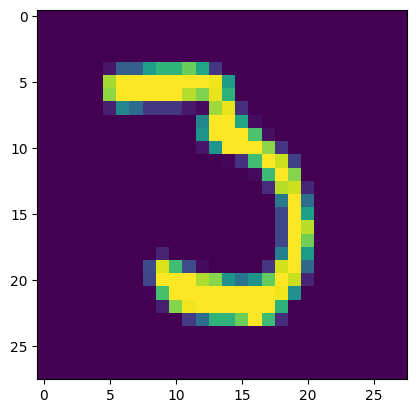

In [16]:
probs = cnn_model(x_test).numpy()
preds = np.argmax(probs, axis=1)
false_mask = preds != y_test

false_images = x_test[false_mask]

print(f"prediction = {preds[false_mask][0]}")
print(f"answer = {y_test[false_mask][0]}")
plt.imshow(false_images[0])

## PyCaret で解く

In [17]:
import numpy as np
import pandas as pd

def flatten(data):
    flat_data = np.array([
        [mat[row, col]
            for row in range(mat.shape[0])
            for col in range(mat.shape[1])]
         for mat in data])
    return flat_data

x_flat_train = flatten(x_train)
x_flat_test = flatten(x_test)

header = list([f"cell_{num:0>3d}" for num in range(0, 784)])
header.append("label")

train_df = pd.DataFrame(
    np.hstack([x_flat_train, np.array([y_train]).T]), columns=header)
test_df = pd.DataFrame(
    np.hstack([x_flat_test, np.array([y_test]).T]), columns=header)

In [ ]:
%%capture
# install pycaret and hide the log by %%capture
!pip install --upgrade pycaret pandas-profiling==3.1.0

In [ ]:
from pycaret import classification

exp = classification.setup(
    data=train_df, target="label", session_id=123, silent=True,
    # 相関関係から数値変数の重複を削除
    remove_multicollinearity = True, multicollinearity_threshold = 0.95,
    pca=True, pca_method="linear")

In [ ]:
best = classification.compare_models()